In [1]:
# Theano/Lasagne
import theano
import lasagne
import theano.tensor as T
from lasagne.utils import floatX
from lasagne.layers import *

# numpy/scipy/scikit
import numpy as np
import skimage.transform

# notebook
from nbtools import display_img_array

# for vgg19 model and conv2dlayer
from vgg_model import load_vgg19, ConvLayer

# neural style helper functions
from ns_helpers import prep_image, imread, get_img, Func, Eval, Shared, deprocess

Using gpu device 0: GeForce GTX 980 (CNMeM is enabled with initial size: 75.0% of memory, CuDNN 4007)
/usr/lib/python3.4/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Set some parameters

In [2]:
# Load vgg19 model and set feature layer for neural matching
net = load_vgg19()

# use conv4_1 for neural matching 
feature_layer = net['conv4_1']
compute_matching_features = theano.function([net['input'].input_var], [get_output(feature_layer)])

# width and height for images (output, input of the vgg19 )
IMAGE_W, IMAGE_H = 640, 480


Use conv to find nearest neighbor of a patch

In [3]:
# builder of best_match
# not using lru_cache because of python 2.7 compatibility
def build_best_match(C, PSIZE, NUM_FILTERS, mem={}):
    key = (C, PSIZE, NUM_FILTERS)
    if key not in mem:
        # compute norm
        input_img = T.tensor4()
        layer_img = InputLayer((1, C, None, None), input_var=input_img)
        layer_sqr_sum = ExpressionLayer(layer_img,  lambda x:T.sum(T.sqr(x), axis=1,keepdims=True) , output_shape=(1,1,None,None))
        layer_norm = ConvLayer(layer_sqr_sum, 1, PSIZE, pad='valid', W=floatX(np.ones((1, 1, PSIZE,PSIZE))), b=None, nonlinearity=T.sqrt)
        layer_norm_reshape = ReshapeLayer(layer_norm, ([2], [3]))
        # compute correlation
        input_patch = T.tensor4()
        patch_sqr_sum = (input_patch**2).sum(axis=3).sum(axis=2).sum(axis=1).reshape((1, NUM_FILTERS, 1, 1))
        layer_prod= ConvLayer(layer_img, NUM_FILTERS, PSIZE, pad='valid', W=input_patch, b=None, nonlinearity=None)
        layer_corr = ElemwiseMergeLayer([layer_prod, layer_norm_reshape], lambda a,b: (a/b)/patch_sqr_sum)
        layer_corr_output = lasagne.layers.get_output(layer_corr)
        # Pack into a function to find the Nearest Neighbor
        mem[key] = theano.function([input_img, input_patch], T.max_and_argmax(layer_corr_output, axis=(2,3))+[T.shape(layer_corr_output)])
    return mem[key]

Scan through the content image, for each PSIZExPSIZE patch in the content image, and find the best match(nearest neighbor) in style image

In [4]:
def match_all(photo_feature, style_feature, PSIZE):
    # there are H rows of patches and W patches at each row.
    H = photo_feature.shape[2]-PSIZE+1
    W = style_feature.shape[3] - PSIZE+1
    C = feature_layer.num_filters
    print(S,C, PSIZE, W, H)

    # build the best_match routine
    best_match = build_best_match(C, PSIZE, W)

    # set up arrays for input patches and output results
    patches = np.zeros( shape=(W, photo_feature.shape[1], PSIZE, PSIZE) ,  dtype= photo_feature.dtype)
    mapping_idx = np.zeros((H,W), dtype='int64')
    mapping_weight = np.zeros((H,W), dtype='float32')

    # doing the match row by row
    for j in range(H):
        for n in range(W):            
                patches[n] = photo_feature[0, :, j:j+PSIZE,n:n+PSIZE ]  
        m, idx, s = best_match(style_feature, patches)
        mapping_idx[j] =idx
        mapping_weight[j] = (m+1)**2  # making the weight positive in a some what arbitrary way    
    return mapping_idx, mapping_weight

In [5]:
def plot_match_result(mapping_idx, mapping_weight, raw_style, psize, method):
    assert mapping_idx.shape == mapping_weight.shape
    assert method in ('max', 'average')
    H, W = mapping_idx.shape
    S = raw_style.shape[1]//(W+PSIZE-1)
    preview = np.zeros(raw_style.shape)
    preview_weight = np.zeros(raw_style.shape)
    for j in range(H):
        for n in range(W):
            y,x = np.unravel_index(mapping_idx[j,n], mapping_idx.shape)
            _preview = preview[j*S:(j+psize)*S, n*S:(n+psize)*S]
            _preview_weight = preview_weight[j*S:(j+psize)*S, n*S:(n+psize)*S]  
            if method == 'max':
                _preview[...] = np.where(_preview_weight < mapping_weight[j,n], raw_style[y*S:(y+psize)*S, x*S:(x+psize)*S], _preview)        
                _preview_weight[...]=np.where(_preview_weight < mapping_weight[j,n], mapping_weight[j,n], _preview_weight)
            else:
                _preview[...] += mapping_weight[j,n]*raw_style[y*S:(y+psize)*S, x*S:(x+psize)*S]
                _preview_weight[...] += mapping_weight[j,n]
    print(preview_weight.min())
    if method == 'average':
        preview /= preview_weight
    return preview

Set and load content image and style image

In [6]:
#from skimage import exposure
img0 = imread("img/smile_face.jpg")
img0 = img0[0:400, 200:800]
img0 = imread('img/tjw1.jpg')
#img0 = imread('img/brad_pitt.jpg')
#img0 = imread("anime_face_by_rayshar-d702kab.jpg")
#p2, p90 = np.percentile(img0, (10, 80))
#img0 = exposure.rescale_intensity(img0, in_range=(p2, p90))
#img0 = (img0*255).astype('uint8')
#img0 = imread("img/Paris-Musee-DOrsay-Vincent-van-Gogh-1889-Self-Portrait-2-Close-Up.jpg")
#img0 = imread("18500729_10.jpg")
#img0 = imread("anime-girl-face-nice-smile.jpg")
#img0 = imread("d1381867.jpg")
#img0 = imread("2015122760189693.jpg")
#img0=imread("f1277177042919.JPG")



img1 = imread("img/Paris-Musee-DOrsay-Vincent-van-Gogh-1889-Self-Portrait-2-Close-Up.jpg")
#img1 = imread("501040_0.jpg")
#img1 = imread("anime_face_by_rayshar-d702kab.jpg")
#img1 = imread("img/picasso_selfport1907.jpg")
#img1 = imread('img/brad_pitt.jpg')
#img1 = imread('img/tjw1.jpg')
img1 = imread("18500729_10.jpg")
#img1 = imread("anime-girl-face-nice-smile.jpg")
#img1 = imread("simpsguestmain.jpg")
#img1 = imread("flanders.png")[:,:,:3]


# load image and compute features for matching
raw_photo, photo = prep_image(img0, 640, 480, 0.)
photo_feature = compute_matching_features(photo)[0]
raw_style, style = prep_image(img1, 640, 480, 0.)
style_feature = compute_matching_features(style)[0]

8 512 7 74 54
1.00568461418
1.00882542133


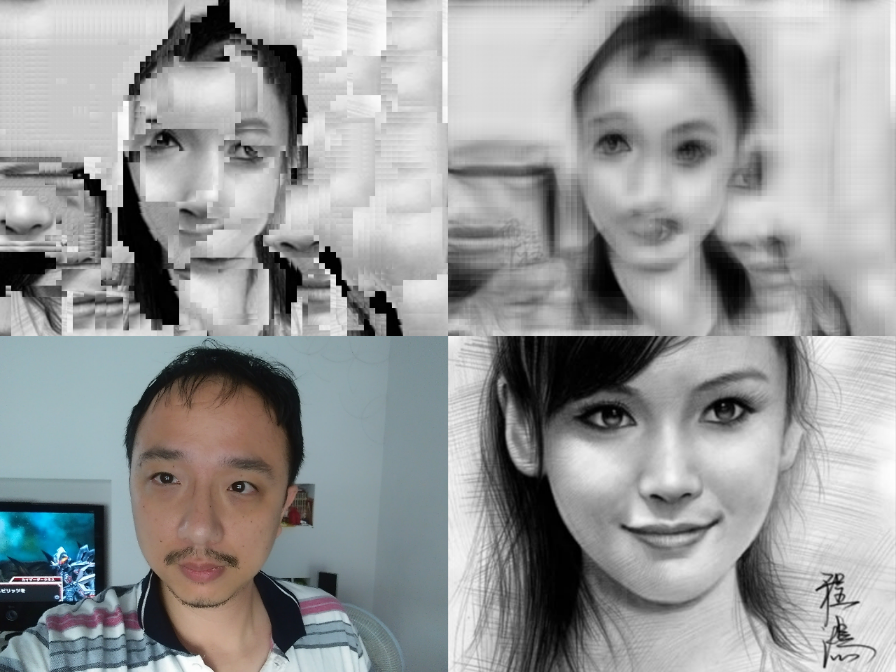

In [7]:
# scale S of the original image to the feature layer 
S = style.shape[3]// style_feature.shape[3]

#PSIZE for patch size
PSIZE = (25//S)*2+1 # some default setting
PSIZE = 7

# match all
mapping_idx, mapping_weight = match_all(photo_feature, style_feature, PSIZE)
# build preview
preview_max = plot_match_result(mapping_idx, mapping_weight, raw_style, PSIZE, "max")
preview_average = plot_match_result(mapping_idx, mapping_weight, raw_style, PSIZE, "average")
# display preview
combine_src1 = skimage.transform.rescale(np.hstack([preview_max, preview_average]), 0.7)/255.
combine_src2 = skimage.transform.rescale(np.hstack([raw_photo, raw_style]), 0.7)
out = np.vstack([combine_src1, combine_src2])
display_img_array(out)

In [8]:
raw_preview, previewx = prep_image(preview_max.astype('uint8'), 640, 480, 0.)
#photo_feature = feature_output.eval({net_input:previewx})

## Neural Style transformation

set content layers and style layers

In [9]:
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
#style_layers = ['conv4_1']
layers = {k: net[k] for k in content_layers+style_layers}

basic norm and loss functions

In [10]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g

def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    loss = 1./2 * lasagne.objectives.squared_error(x, p).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)).sum()

In [11]:
raw_content, content = prep_image(get_img(img0), IMAGE_W, IMAGE_H)
raw_style, style = prep_image(get_img(img1), IMAGE_W, IMAGE_H)
input_image = Shared((IMAGE_W, "input"), style)
outputs = lasagne.layers.get_output(layers.values(), input_image)
input_image.set_value(style)
style_features = {k: Shared((IMAGE_W, "style_"+k), Eval((IMAGE_W, k), output)) for k, output in zip(layers.keys(), outputs)}
input_image.set_value(content)
content_features = {k: Shared((IMAGE_W, "content_"+k), Eval((IMAGE_W, k), output)) for k, output in zip(layers.keys(), outputs)}

/home/tjw/.local/lib/python3.4/site-packages/scikit_image-0.13dev-py3.4-linux-x86_64.egg/skimage/filters/_gaussian.py:94: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


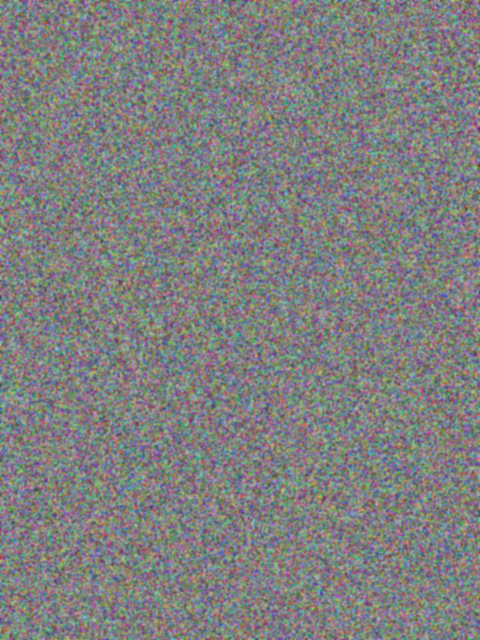

In [12]:
import skimage.filters
generated_image = input_image
init_img = skimage.filters.gaussian(np.random.uniform(-128, 128, (IMAGE_W, IMAGE_H, 3)), 1)
display_img_array( (init_img+128).astype('uint8'))
init_img = np.swapaxes(init_img, 0,2).reshape(1,3,IMAGE_H, IMAGE_W)
generated_image.set_value(floatX(init_img))
#generated_image.set_value(previewx)
gen_features = {k: v for k, v in zip(layers.keys(), outputs)}   

In [13]:
def plot_match_result_with_a2(mapping_idx, mapping_weight, raw_style, psize, method):
    assert mapping_idx.shape == mapping_weight.shape
    assert method in ('max', 'average')
    H, W = mapping_idx.shape
    S = raw_style.shape[3]//(W+PSIZE-1)
    preview = np.zeros(raw_style.shape)
    a2 = np.zeros(raw_style.shape)
    preview_weight = np.zeros(raw_style.shape)
    for j in range(H):
        for n in range(W):
            y,x = np.unravel_index(mapping_idx[j,n], mapping_idx.shape)
            _preview = preview[:,:,j*S:(j+psize)*S, n*S:(n+psize)*S]
            _preview_weight = preview_weight[:,:,j*S:(j+psize)*S, n*S:(n+psize)*S]  
            _a2 = a2[:,:,j*S:(j+psize)*S, n*S:(n+psize)*S] 
            w = mapping_weight[j,n]
            if method == 'max':
                _preview[...] = np.where(_preview_weight < w, raw_style[:,:,y*S:(y+psize)*S, x*S:(x+psize)*S], _preview)        
                _preview_weight[...]=np.where(_preview_weight < w, w, _preview_weight)
                _a2 = np.where(_preview_weight < w, raw_style[:,:,y*S:(y+psize)*S, x*S:(x+psize)*S]**2,_a2)
            else:
                _preview[...] += w*raw_style[:,:,y*S:(y+psize)*S, x*S:(x+psize)*S]
                _preview_weight[...] += w
                _a2 += w * raw_style[:,:,y*S:(y+psize)*S, x*S:(x+psize)*S]**2
    if method == 'average':
        preview /= preview_weight
        a2 /= preview_weight
    return preview, a2

In [14]:
method = ("average", "max")[0]
style_a = {}
style_a2 = {}
for k,a in style_features.items():
    npa = np.array(a.eval())
    npA, A2 = plot_match_result_with_a2(mapping_idx, mapping_weight, npa, PSIZE, method)
    #print(k, (style_a[k].eval() - npA).max())
    #print(k, style_a2[k] - (A2).sum())
    style_a[k] = Shared((IMAGE_W, 'A_'+k), floatX(npA))
    style_a2[k] = Shared((IMAGE_W, 'A2_'+k), floatX(A2.sum())) 

In [15]:
def style_loss(A, A2, X, layer):    
    a = A[layer]
    a2 = A2[layer]
    x = X[layer]
    s = x.shape.eval()
    loss = (x**2).sum()+a2-2*(x*a).sum()
    return loss/(s[1]*s[2]*s[3])

In [16]:
#tv_loss = 0.1e-7 * total_variation_loss(generated_image) 
tv_loss = 0.1e-7 * total_variation_loss(generated_image) 
c_loss = 0.
for layer in content_layers:
       c_loss += 3 * 0.001 * content_loss(content_features, gen_features, layer)
s_loss = 0.
for layer in style_layers:
        s_loss += 0.2e6 * style_loss(style_a, style_a2,  gen_features, layer)
total_loss = tv_loss + c_loss+ s_loss
f_errors = Func((IMAGE_W, 'errors'), [], [tv_loss, c_loss, s_loss])

In [17]:
def eval_loss(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_H, IMAGE_W)))
    generated_image.set_value(x0)
    return f_loss().astype('float64')

def eval_grad(x0):
    #x0 = floatX(x0.reshape((1, 3, IMAGE_H, IMAGE_W)))
    #generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')

In [18]:
grad = T.grad(total_loss, generated_image)
# Theano functions to evaluate loss and gradient
f_loss = Func((IMAGE_W, "loss"), [], total_loss)        
f_grad = Func((IMAGE_W, "grad"), [], grad)        
x0 = generated_image.get_value().astype('float64')

In [19]:
import scipy.optimize

In [20]:
from IPython.display import clear_output

4 348626.9764811198 [0.46949636936187744, 3589.72314453125, 345036.7838541667]


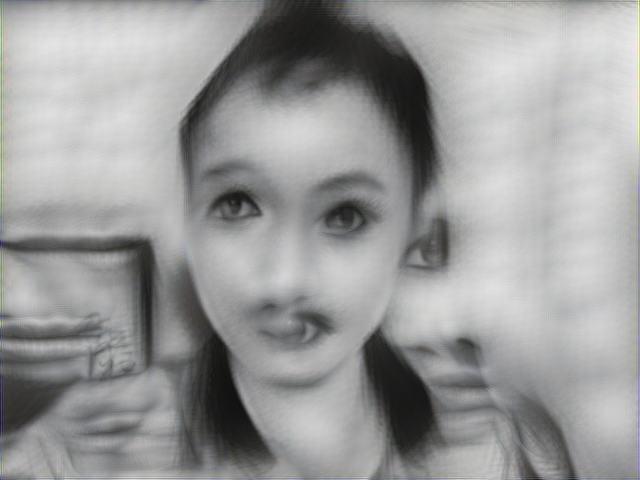

In [ ]:
for i in range(5):
    x, loss, d = scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)    
    x0 = generated_image.get_value().astype('float64')    
    errors = [float(x) for x in f_errors()]
    clear_output()
    print(i, loss, errors)
    display_img_array(deprocess(x0))

In [ ]:
for i in range(50):
    x, loss, d = scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)    
    x0 = generated_image.get_value()   
    errors = [float(x) for x in f_errors()]
    clear_output()
    print(i, loss, errors)
    dx0 = deprocess(x0)
    display_img_array(dx0)
    x0_feature = compute_matching_features(x0)[0]
    mapping_idx, mapping_weight = match_all(x0_feature, style_feature, PSIZE)
    for k,a in style_features.items():
        npa = np.array(a.eval())
        npA, A2 = plot_match_result_with_a2(mapping_idx, mapping_weight, npa, PSIZE, method)       
        Shared((IMAGE_W, 'A_'+k), floatX(npA))
        Shared((IMAGE_W, 'A2_'+k), floatX(A2.sum()))

In [ ]:
combine_src = skimage.transform.rescale(np.hstack([raw_photo, raw_style]), 0.5)
out = np.vstack([deprocess(x0)/255, combine_src])
display_img_array(out)
















